In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR

In [31]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns

In [4]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Data

In [6]:
train_df = pd.read_csv('/content/drive/MyDrive/ECG Heartbeat Dataset/mitbih_train.csv', header=None)
test_df = pd.read_csv('/content/drive/MyDrive/ECG Heartbeat Dataset/mitbih_test.csv', header=None)

print(train_df.shape)
print(test_df.shape)

(87554, 188)
(21892, 188)


In [7]:
X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values.astype(int)

X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values.astype(int)

In [8]:
class_names = ['Normal', 'Supraventricular', 'Ventricular', 'Fusion', 'Unclassifiable']

print("Train data class distribution\n")
for i in range(len(class_names)):
    count = np.sum(y_train == i)
    percentage = 100 * count / len(y_train)
    print(f"{class_names[i]}: {count} ({percentage:.2f}%)")

print("\nTest data class distribution\n")
for i in range(len(class_names)):
    count = np.sum(y_test == i)
    percentage = 100 * count / len(y_test)
    print(f"{class_names[i]}: {count} ({percentage:.2f}%)")

Train data class distribution

Normal: 72471 (82.77%)
Supraventricular: 2223 (2.54%)
Ventricular: 5788 (6.61%)
Fusion: 641 (0.73%)
Unclassifiable: 6431 (7.35%)

Test data class distribution

Normal: 18118 (82.76%)
Supraventricular: 556 (2.54%)
Ventricular: 1448 (6.61%)
Fusion: 162 (0.74%)
Unclassifiable: 1608 (7.35%)


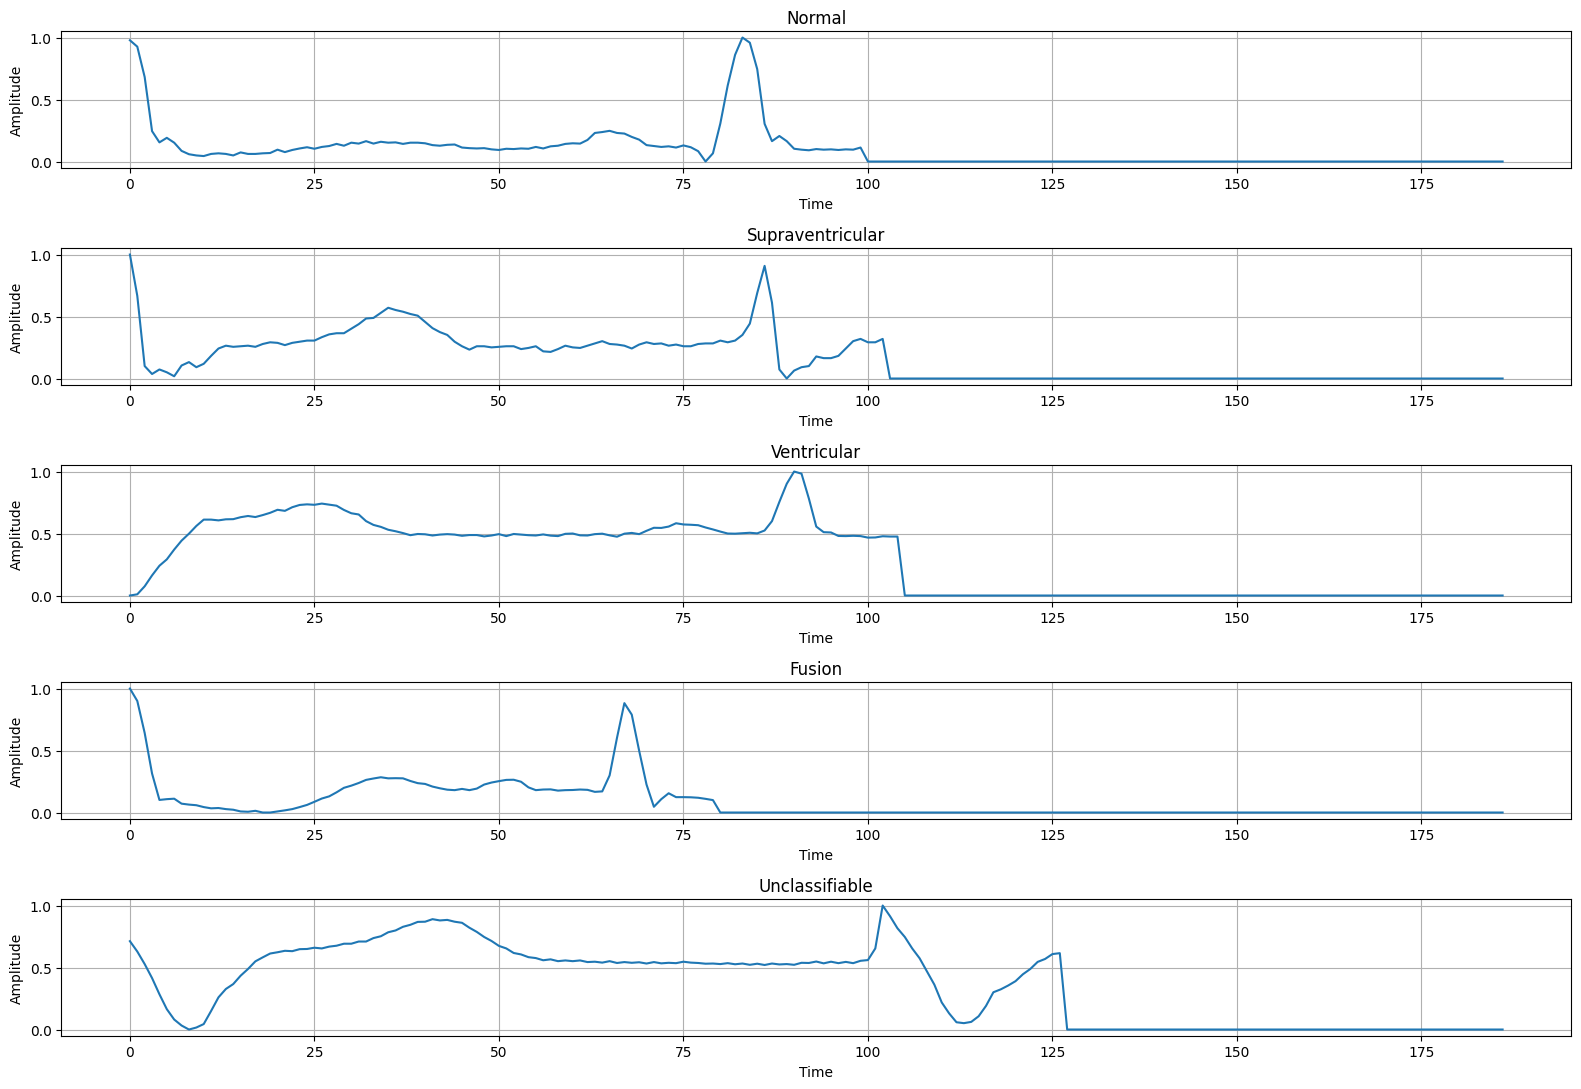

In [9]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(16, 11))

for i, class_name in enumerate(class_names):
    first_idx = np.where(y_train == i)[0][0]
    heartbeat = X_train[first_idx]

    axes[i].plot(heartbeat)
    axes[i].set_title(class_name)
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Amplitude')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# split scaled data to val and test
X_val, X_test_final, y_val, y_test_final = train_test_split(
    X_test_scaled,
    y_test,
    test_size=0.5,
    random_state=42,
    stratify=y_test
)

print(f"Train: {len(X_train_scaled)}")
print(f"Val:   {len(X_val)}")
print(f"Test:  {len(X_test_final)}")

Train: 87554
Val:   10946
Test:  10946


In [ ]:
# data augmentation

class GaussianNoise:
    def __init__(self, mean=0., std=0.03, p=0.5):  
        self.std = std
        self.mean = mean
        self.p = p

    def __call__(self, signal):
        if random.random() < self.p:
            noise = np.random.normal(self.mean, self.std, signal.shape).astype(np.float32)
            return signal + noise
        return signal


class TimeShifting:
    def __init__(self, max_shift=10, p=0.5):
        self.max_shift = max_shift
        self.p = p

    def __call__(self, signal):
        if random.random() < self.p:
            shift = np.random.randint(-self.max_shift, self.max_shift + 1)
            return np.roll(signal, shift)
        return signal


class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, signal):
        for t in self.transforms:
            signal = t(signal)
        return signal

In [13]:
class ECGDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        signal = self.X[idx].copy()
        label = self.y[idx]

        if self.transform is not None:
            signal = self.transform(signal)

        signal = torch.FloatTensor(signal).unsqueeze(0)
        label = torch.LongTensor([label]).squeeze()

        return signal, label

In [14]:
transform = Compose([GaussianNoise(), TimeShifting()])
train_dataset = ECGDataset(X_train_scaled, y_train, transform=transform)
val_dataset = ECGDataset(X_val, y_val)
test_dataset = ECGDataset(X_test_final, y_test_final)

In [15]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model

### Architecture: Hybrid CNN + LSTM with a multihead attention layer



In [16]:
class CNN_BiLSTM_MultiHeadAttention(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()

        # Conv Blocks (
        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2)
        self.dropout1 = nn.Dropout(0.2)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2)
        self.dropout2 = nn.Dropout(0.2)

        self.conv3 = nn.Conv1d(128, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.2)

        # BiLSTM Block
        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=64,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        self.bn4 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(0.3)

        # Multi head attention
        self.attention = nn.MultiheadAttention(
            embed_dim=128,
            num_heads=4,
            dropout=0.1,
            batch_first=True
        )

        # FC block
        self.fc1 = nn.Linear(128, 64)
        self.bn5 = nn.BatchNorm1d(64)
        self.dropout5 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.dropout3(x)

        x = x.permute(0, 2, 1)  # (batch, channels, seq) -> (batch, seq, channels)
        lstm_output, _ = self.lstm(x)

        x = lstm_output.permute(0, 2, 1)
        x = self.bn4(x)
        x = x.permute(0, 2, 1)  # (batch, seq, channels) -> (batch, channels, seq)
        x = self.dropout4(x)

        attn_output, _ = self.attention(x, x, x)  # (batch, seq_len, 128)

        # Global average pooling
        x = attn_output.mean(dim=1)


        x = F.relu(self.fc1(x))
        x = self.bn5(x)
        x = self.dropout5(x)

        x = self.fc2(x)

        return x

In [17]:
# class weighting because data is heavily imbalanced
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.FloatTensor(class_weights).to(device)
print(class_weights)

tensor([ 0.2416,  7.8771,  3.0254, 27.3179,  2.7229], device='cuda:0')


In [18]:
model = CNN_BiLSTM_MultiHeadAttention().to(device)

In [19]:
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [20]:
warmup = LinearLR(optimizer, start_factor=0.1, total_iters=5)
cosine = CosineAnnealingLR(optimizer, T_max=95, eta_min=1e-6)
scheduler = SequentialLR(optimizer, schedulers=[warmup, cosine], milestones=[5])

# Training

In [21]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy


def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy

In [ ]:
num_epochs = 100
patience = 20
train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_val_acc = 0.0
no_improve = 0

print(f"{'Epoch':<10} {'Train Loss':<14} {'Train Acc':<14} {'Val Loss':<14} {'Val Acc':<14}")
print("="*80)

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device) 

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    scheduler.step()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve = 0
        torch.save(model.state_dict(), 'best_ecg_model.pth')
        print(f'{epoch+1:<10} {train_loss:<14.4f} {train_acc:<14.2f}% {val_loss:<14.4f} {val_acc:<14.2f}% * BEST')
    else:
        no_improve += 1
        print(f'{epoch+1:<10} {train_loss:<14.4f} {train_acc:<14.2f}% {val_loss:<14.4f} {val_acc:<14.2f}%')

    if no_improve >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

print(f'\nBest validation accuracy: {best_val_acc:.2f}%')

Epoch      Train Loss     Train Acc      Val Loss       Val Acc       
1          1.0590         28.43         % 0.6811         49.57         % * BEST
2          0.6710         64.23         % 0.4662         84.64         % * BEST
3          0.5244         79.48         % 0.4114         86.05         % * BEST
4          0.4429         82.86         % 0.3553         91.96         % * BEST
5          0.4166         84.34         % 0.4053         91.08         %
6          0.4196         84.17         % 0.3121         86.71         %
7          0.3627         86.28         % 0.3222         89.04         %
8          0.3300         87.62         % 0.3400         86.62         %
9          0.3204         87.78         % 0.2490         91.27         %
10         0.3060         88.42         % 0.2567         90.48         %
11         0.2837         88.65         % 0.2946         84.98         %
12         0.2745         89.51         % 0.2989         90.53         %
13         0.2607        

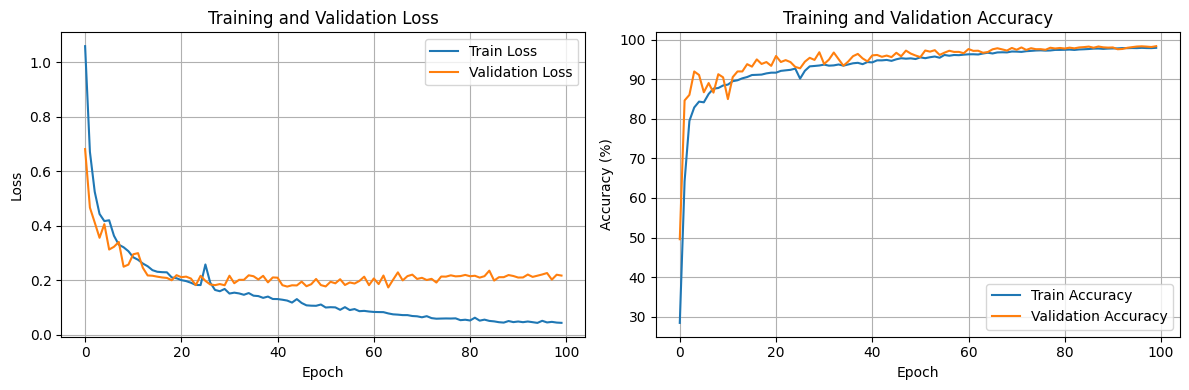

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# loss
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)


# accuracy
ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(val_accs, label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Testing / Evalutation

In [28]:
class_names = ['Normal', 'Supraventricular', 'Ventricular', 'Fusion', 'Unclassifiable']
model.eval()
model.load_state_dict(torch.load('best_ecg_model.pth'))

y_true = []
y_pred = []
y_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_probs.extend(probabilities.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_probs = np.array(y_probs)

accuracy = accuracy_score(y_true, y_pred) * 100
print(f'Test Accuracy: {accuracy:.2f}%')

for i in range(5):
    class_filter = y_true == i
    class_accuracy = accuracy_score(y_true[class_filter], y_pred[class_filter])
    class_correct = np.sum((y_true[class_filter]) == y_pred[class_filter])
    class_total = np.sum(class_filter)
    print(f"Class {class_names[i]} accuracy: {class_accuracy:.2f}% ({class_correct}/{class_total})")

Test Accuracy: 98.25%
Class Normal accuracy: 0.99% (8948/9059)
Class Supraventricular accuracy: 0.87% (243/278)
Class Ventricular accuracy: 0.95% (689/724)
Class Fusion accuracy: 0.94% (76/81)
Class Unclassifiable accuracy: 0.99% (798/804)


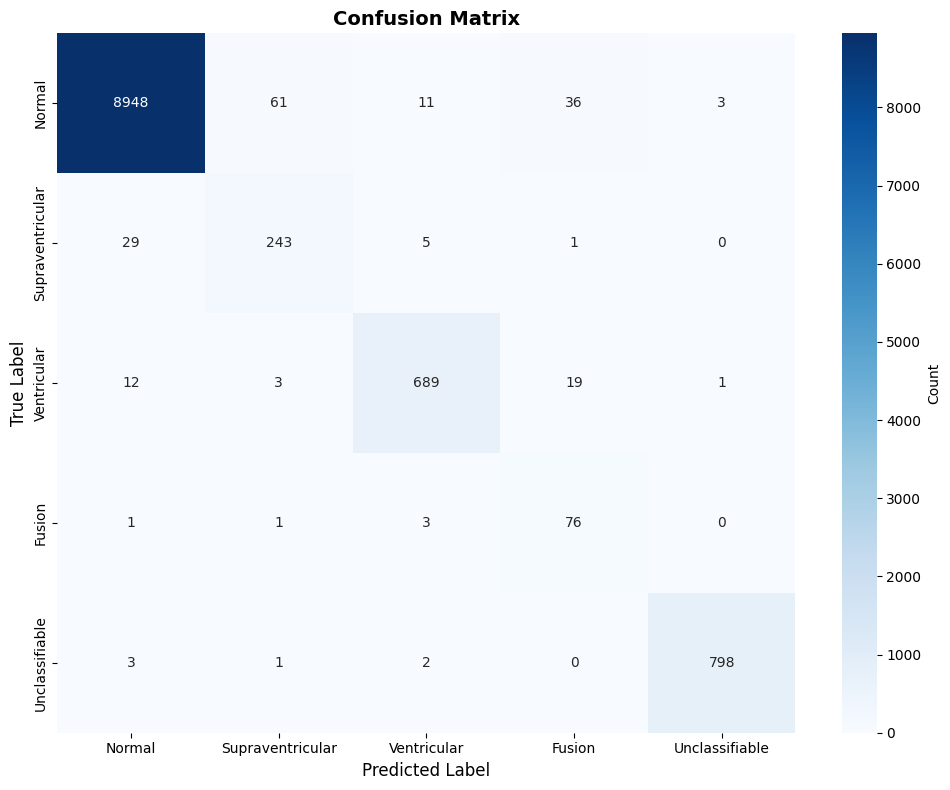

In [32]:
# confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})

plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()